In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl
from sklearn import neighbors
import copy
from sklearn.cluster import DBSCAN
import emcee
import pandas as pd
import rasterio
from rasterio.plot import show

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, [1,500], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

# 1. Load the Data (just one event for now)

## 1.1 File name

In [25]:
files_list = sorted(glob('/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/*'))

event_file = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_2024-12-18_23.56.00_UTC.h5'

## 1.2 Load the data

In [26]:
f = h5py.File(event_file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

## 1.3 Filter the data

In [170]:
sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

# 2. Use Obspy for picking

## 2.1 Test the picking over individual channels

In [171]:
class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)

In [172]:
channel = 300
channel_slice = filtered[:,channel]


DAS_channel = DAS(channel, channel_slice, attrs, times)

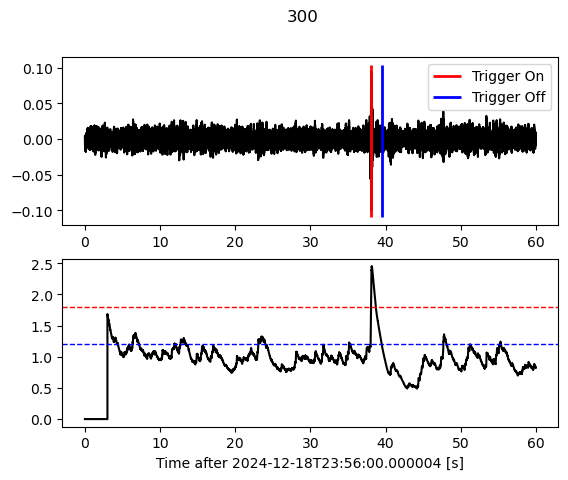

In [173]:
cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(3 * fs))
plot_trigger(DAS_channel, cft, 1.8, 1.2)

In [174]:
trigger_times = trigger_onset(cft, 1.7, 1.2)

## 2.2 Test the picking over each channel in a loop

In [175]:
channels_arr = np.arange(0, attrs['NumberOfLoci'],1)

trigger_on = 1.8
trigger_off = 1.2

trigger_times_list = []

for i in channels_arr:

    channel_slice = filtered[:,i]
    DAS_channel = DAS(i, channel_slice, attrs, times)

    cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(3 * fs))
    trigger_times = trigger_onset(cft, trigger_on, trigger_off)

    trigger_times_list.append(trigger_times)




(285.0, 350.0)

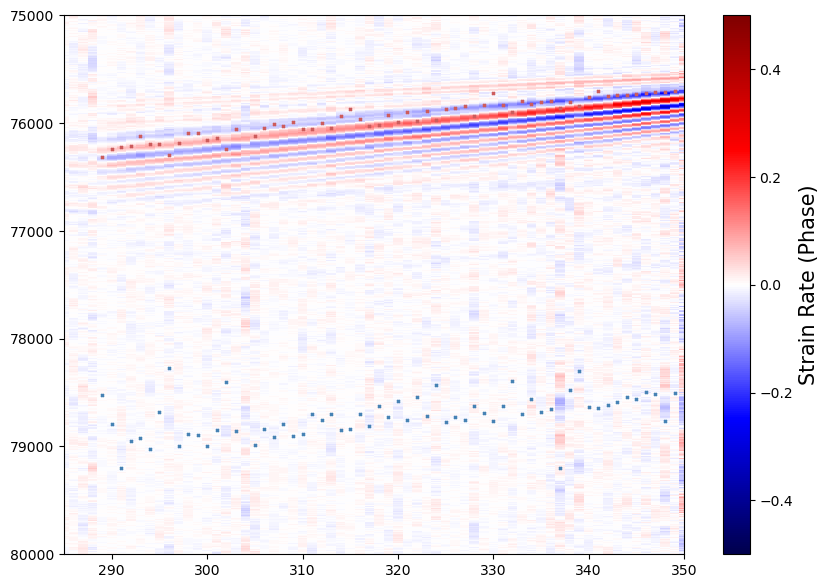

In [283]:
v = 0.5



# fig, ax = plt.subplots(figsize=(10,7))
# fig.patch.set_alpha(0)
# im = ax.imshow(filtered, vmin=-v, vmax=v, cmap='seismic', aspect='auto')
# cb = fig.colorbar(im, ax=ax)
# cb.set_label('Strain Rate (Phase)', fontsize=15)

fig, ax = plt.subplots(figsize=(10,7))
fig.patch.set_alpha(0)
im = ax.pcolormesh(channels_arr, np.arange(1,filtered.shape[0]+1,1), filtered, vmin=-v, vmax=v, cmap='seismic')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Strain Rate (Phase)', fontsize=15)

t1 = 37.5
t2 = 40
ax.set_ylim([int(times.shape[0]/60*t2), int(times.shape[0]/60*t1)])

for n,i in enumerate(trigger_times_list):
    trigs_arr = np.array(i)
    if not trigs_arr.any():
        continue
    else:
        chan_plot = np.array([n]*trigs_arr.shape[0])
        trig_start_time =  np.array(i)[:,0]
        trig_off_time = np.array(i)[:,1]
        ax.scatter(chan_plot, trig_start_time, marker='x',color='indianred', s=4)
        ax.scatter(chan_plot, trig_off_time, marker='x',color='steelblue', s=4)
ax.set_xlim([285,350])

In [186]:
times

array([datetime.datetime(2024, 12, 19, 4, 1, 0, 3),
       datetime.datetime(2024, 12, 19, 4, 1, 0, 496),
       datetime.datetime(2024, 12, 19, 4, 1, 0, 999), ...,
       datetime.datetime(2024, 12, 19, 4, 1, 59, 998501),
       datetime.datetime(2024, 12, 19, 4, 1, 59, 999004),
       datetime.datetime(2024, 12, 19, 4, 1, 59, 999497)], dtype=object)

# 3. Ok. Big time stuff now. Do the picking on all data

## 3.1 This works, but misses the first 5 secs of all files.

In [56]:
all_trigger_times = []

for file in tqdm(files_list):
    try:
        f = h5py.File(file)
        attrs = f['Acquisition'].attrs
        data = f['Acquisition']['Raw[0]']['RawData'][:]
        times = sintela_to_datetime(f['Acquisition']['Raw[0]']['RawDataTime'][:])
        fs = attrs['PulseRate']
        dx = attrs['SpatialSamplingInterval']
        channels = np.arange(1, attrs['NumberOfLoci']+1,1)

        sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
        filtered = signal.sosfiltfilt(sos, data, axis=0)

        channels_arr = np.arange(0, attrs['NumberOfLoci'],1)

        trigger_on = 1.7
        trigger_off = 1.2

        trigger_times_list = []

        for i in channels_arr:

            channel_slice = filtered[:,i]
            DAS_channel = DAS(i, channel_slice, attrs, times)

            cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(5 * fs))
            trigger_times = trigger_onset(cft, trigger_on, trigger_off)

            trigger_times_list.append(trigger_times)

        trigger_times_list_datetime = []

        for trigs_samp_time in trigger_times_list:
            trigger_times_list_datetime.append(times[trigs_samp_time])
        
        all_trigger_times.append(trigger_times_list_datetime)
    except:
        all_trigger_times.append([])


100%|██████████| 756/756 [32:27<00:00,  2.58s/it]


'/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_2024-12-18_04.54.17_UTC.h5'

## 3.2 Working to have overlapping data so first 5 secs are not missed in the picking

## 3.2.1 Code below just concats the next data array to the previous

In [78]:
trigger_on = 1.7
trigger_off = 1.2

all_trigger_times = []

for i in tqdm(range(len(files_list))):
    if i == 0:
        
        filt_filled_data, times, attrs = preprocessing_step(files_list[i])
        print(times)
        

    else:
        first = copy.deepcopy(filt_filled_data)
        times_first = copy.deepcopy(times)

        filt_filled_data, times, attrs = preprocessing_step(files_list[i])
        
        # overlap_data[:,:] = filt_filled_data

        all_data = np.concatenate((first,filt_filled_data), axis=0)
        times_all = np.concatenate((times_first,times), axis=0)

        channels_arr = np.arange(0, attrs['NumberOfLoci'],1)


        trigger_times_list = []     

        for j in channels_arr:

            channel_slice = all_data[:,j]
            DAS_channel = DAS(j, channel_slice, attrs, times_all)

            cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(5 * fs))
            trigger_times = trigger_onset(cft, trigger_on, trigger_off)

            trigger_times_list.append(trigger_times)

        trigger_times_list_datetime = []

        for trigs_samp_time in trigger_times_list:
            trigger_times_list_datetime.append(times_all[trigs_samp_time])
        
        all_trigger_times.append(trigger_times_list_datetime)      
          
        # fig,ax = plt.subplots()
        # ax.imshow(all_data,aspect='auto', vmin=-0.05,vmax=0.05)
    if i == 5:
        break

  0%|          | 1/756 [00:01<22:48,  1.81s/it]

[datetime.datetime(2024, 12, 18, 4, 54, 17, 124002)
 datetime.datetime(2024, 12, 18, 4, 54, 17, 124504)
 datetime.datetime(2024, 12, 18, 4, 54, 17, 124997) ...
 datetime.datetime(2024, 12, 18, 4, 54, 59, 998502)
 datetime.datetime(2024, 12, 18, 4, 54, 59, 998995)
 datetime.datetime(2024, 12, 18, 4, 54, 59, 999498)]
[    0     1     2 ... 85749 85750 85751]
[datetime.datetime(2024, 12, 18, 4, 54, 17, 124002)
 datetime.datetime(2024, 12, 18, 4, 54, 17, 124504)
 datetime.datetime(2024, 12, 18, 4, 54, 17, 124997) ... 0 0 0]
[datetime.datetime(2024, 12, 18, 4, 55, 0, 1)
 datetime.datetime(2024, 12, 18, 4, 55, 0, 504)
 datetime.datetime(2024, 12, 18, 4, 55, 0, 997) ...
 datetime.datetime(2024, 12, 18, 4, 55, 59, 998499)
 datetime.datetime(2024, 12, 18, 4, 55, 59, 999002)
 datetime.datetime(2024, 12, 18, 4, 55, 59, 999505)]
[     0      1      2 ... 119997 119998 119999]


  0%|          | 2/756 [00:05<38:53,  3.10s/it]

[datetime.datetime(2024, 12, 18, 4, 55, 59, 999998)
 datetime.datetime(2024, 12, 18, 4, 56, 0, 500)
 datetime.datetime(2024, 12, 18, 4, 56, 0, 1003) ...
 datetime.datetime(2024, 12, 18, 4, 56, 59, 998495)
 datetime.datetime(2024, 12, 18, 4, 56, 59, 998998)
 datetime.datetime(2024, 12, 18, 4, 56, 59, 999501)]
[     0      1      2 ... 119997 119998 119999]


  0%|          | 3/756 [00:09<44:09,  3.52s/it]

[datetime.datetime(2024, 12, 18, 4, 57, 0, 4)
 datetime.datetime(2024, 12, 18, 4, 57, 0, 497)
 datetime.datetime(2024, 12, 18, 4, 57, 0, 1000) ...
 datetime.datetime(2024, 12, 18, 4, 57, 59, 998502)
 datetime.datetime(2024, 12, 18, 4, 57, 59, 999005)
 datetime.datetime(2024, 12, 18, 4, 57, 59, 999498)]
[     0      1      2 ... 119997 119998 119999]


  1%|          | 4/756 [00:13<46:35,  3.72s/it]

[datetime.datetime(2024, 12, 18, 4, 58)
 datetime.datetime(2024, 12, 18, 4, 58, 0, 503)
 datetime.datetime(2024, 12, 18, 4, 58, 0, 996) ...
 datetime.datetime(2024, 12, 18, 4, 58, 59, 998498)
 datetime.datetime(2024, 12, 18, 4, 58, 59, 999001)
 datetime.datetime(2024, 12, 18, 4, 58, 59, 999504)]
[     0      1      2 ... 119997 119998 119999]


  1%|          | 5/756 [00:17<47:55,  3.83s/it]

[datetime.datetime(2024, 12, 18, 4, 58, 59, 999997)
 datetime.datetime(2024, 12, 18, 4, 59, 0, 500)
 datetime.datetime(2024, 12, 18, 4, 59, 0, 1003) ...
 datetime.datetime(2024, 12, 18, 4, 59, 59, 998505)
 datetime.datetime(2024, 12, 18, 4, 59, 59, 998998)
 datetime.datetime(2024, 12, 18, 4, 59, 59, 999500)]
[     0      1      2 ... 119997 119998 119999]


  1%|          | 5/756 [00:21<54:46,  4.38s/it]


In [82]:
np.arange(datetime.datetime(2024, 12, 18, 4, 54, 0, 0), datetime.datetime(2024, 12, 18, 4, 54, 17, 124002), 500).shape

(34249,)

In [83]:
85751 + 34249

120000

In [80]:
datetime.datetime(2024, 12, 18, 4, 54, 17, 124002) - datetime.datetime(2024, 12, 18, 4, 54, 0, 0)

datetime.timedelta(seconds=17, microseconds=124002)

## 3.2.2 Testing with checking if the stattime is on the top of the minute or not.

In [ ]:
trigger_on = 1.8
trigger_off = 1.2

all_trigger_times = []

for i in tqdm(range(len(files_list))):
    if files_list[i][-9:-7] != '00':
        try:
            filt_filled_data, times, attrs = preprocessing_step(files_list[i])
        except: 
            continue
        

    else:
        first = copy.deepcopy(filt_filled_data)
        times_first = copy.deepcopy(times)
        try:
            filt_filled_data, times, attrs = preprocessing_step(files_list[i])
        except:
            continue
        
        # overlap_data[:,:] = filt_filled_data

        all_data = np.concatenate((first,filt_filled_data), axis=0)
        times_all = np.concatenate((times_first,times), axis=0)

        channels_arr = np.arange(0, attrs['NumberOfLoci'],1)


        trigger_times_list = []     

        for j in channels_arr:

            channel_slice = all_data[:,j]
            DAS_channel = DAS(j, channel_slice, attrs, times_all)

            cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(3 * fs))
            trigger_times = trigger_onset(cft, trigger_on, trigger_off)

            trigger_times_list.append(trigger_times)

        trigger_times_list_datetime = []

        for trigs_samp_time in trigger_times_list:
            trigger_times_list_datetime.append(times_all[trigs_samp_time])
        
        all_trigger_times.append(trigger_times_list_datetime)      
          
        # fig,ax = plt.subplots()
        # ax.imshow(all_data,aspect='auto', vmin=-0.05,vmax=0.05)
    # if i == 5:
    #     break

# with open('all_chan_all_trigger_times_overlapped_new_STALTA.pkl', 'wb') as file:
#     # Serialize and write the data to the file
#     pkl.dump(all_trigger_times, file)

100%|██████████| 756/756 [48:28<00:00,  3.85s/it]


In [ ]:
# with open('all_chan_all_trigger_times_overlapped.pkl', 'wb') as file:
#     # Serialize and write the data to the file
#     pkl.dump(all_trigger_times, file)

# 4. Start here for using trigger times

In [2]:
with open('all_chan_all_trigger_times_overlapped_new_STALTA.pkl', 'rb') as file:
    # Serialize and write the data to the file
    list_of_times = pkl.load(file)

# 5. Plot a single set of triggers to check accuracy

In [3]:
## Print an example list of triggers ##
""" Triggers from one file """
files_list = sorted(glob('/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/*'))
file_number = 677

triggers_of_interest = list_of_times[file_number]
event_files = files_list[file_number+2: file_number+4]

In [4]:
### Get the data that the triggers had triggered on ###

for n, i in enumerate(event_files):
    if n == 0:

        filt_filled_data, times, attrs = preprocessing_step(i)
    else:
        first_data = copy.deepcopy(filt_filled_data)
        first_times = copy.deepcopy(times)

        filt_filled_data, times, attrs = preprocessing_step(i)

        all_data = np.concatenate((first_data, filt_filled_data), axis=0)
        all_times = np.concatenate((first_times, times), axis=0)
channels_arr = np.arange(0, attrs['NumberOfLoci'],1)

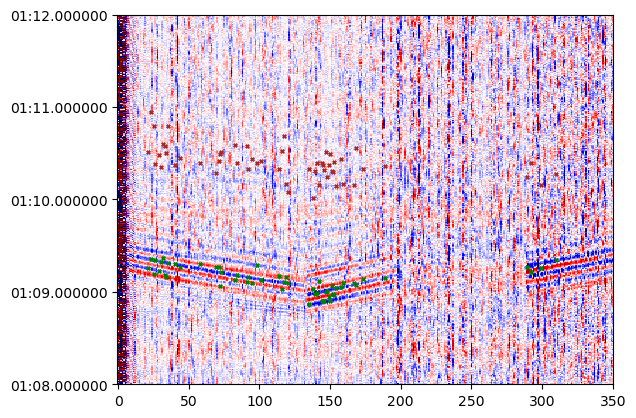

In [5]:
### Plot the data ###

fig, ax = plt.subplots()

ax.pcolormesh(channels_arr, all_times, all_data, vmin=-0.05, vmax=0.05, cmap='seismic')

for n,i in enumerate(triggers_of_interest):
    trigs_arr = np.array(i)
    if not trigs_arr.any():
        continue
    else:
        chan_plot = np.array([n]*trigs_arr.shape[0])
        trig_start_time =  np.array(i)[:,0]
        trig_off_time = np.array(i)[:,1]


        ax.scatter(chan_plot, trig_start_time, marker='x',color='green', s=6)
        ax.scatter(chan_plot, trig_off_time, marker='x',color='brown', s=6)

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 8, 0),datetime.datetime(2024, 12, 19, 4, 1, 12, 0)])
plt.show()

# 6. Cull some of the detections for duplicates and erroneous triggers

## 6.1 Remove duplicates

In [6]:
def remove_nearby_datetimes(datetime_list, threshold_seconds):
    """
    Removes datetime values from a list that are within a specified time threshold of each other.

    Args:
        datetime_list: A list of datetime objects.
        threshold_seconds: The threshold in seconds to consider datetimes as "near" each other.

    Returns:
        A new list with the nearby datetimes removed.
    """
    if not datetime_list:
        return []

    datetime_list.sort()  # Ensure datetimes are in chronological order
    result = [datetime_list[0]]
    last_added = datetime_list[0]

    for dt in datetime_list[1:]:
        if (dt - last_added).total_seconds() > threshold_seconds:
            result.append(dt)
            last_added = dt

    return result

## 6.2 Remove triggers that happen at the start of the window.

In [7]:
all_chans_all_detects_culled = {}
for chan_number in np.arange(0,351,1):
    chan_detects = []


    for n, i in enumerate(list_of_times):
        """ Below this is the code to check for the bad triggers on start"""

        if n ==0:
            continue

        if i[chan_number].any():


            first_detect = np.asarray(i[chan_number])[:,0][0]

            if isinstance(first_detect, int):
                continue
            time_start = datetime.datetime(year = first_detect.year, 
                                           month=first_detect.month, 
                                           day=first_detect.day, 
                                           hour=first_detect.hour, 
                                           minute=first_detect.minute
                                           )
            event_time_within_minute = first_detect - time_start

            second_of_detect = event_time_within_minute.seconds + event_time_within_minute.microseconds/1e6

            if 2.9 < second_of_detect < 4:

                """ Below this it remains the same"""
                for j in i[chan_number][1:]: #skip the first one

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
            else:
                for j in i[chan_number]:

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
    

    culled = remove_nearby_datetimes(chan_detects, 0.5)

    all_chans_all_detects_culled[str(chan_number)] = culled


# 7.1 Show all the detections

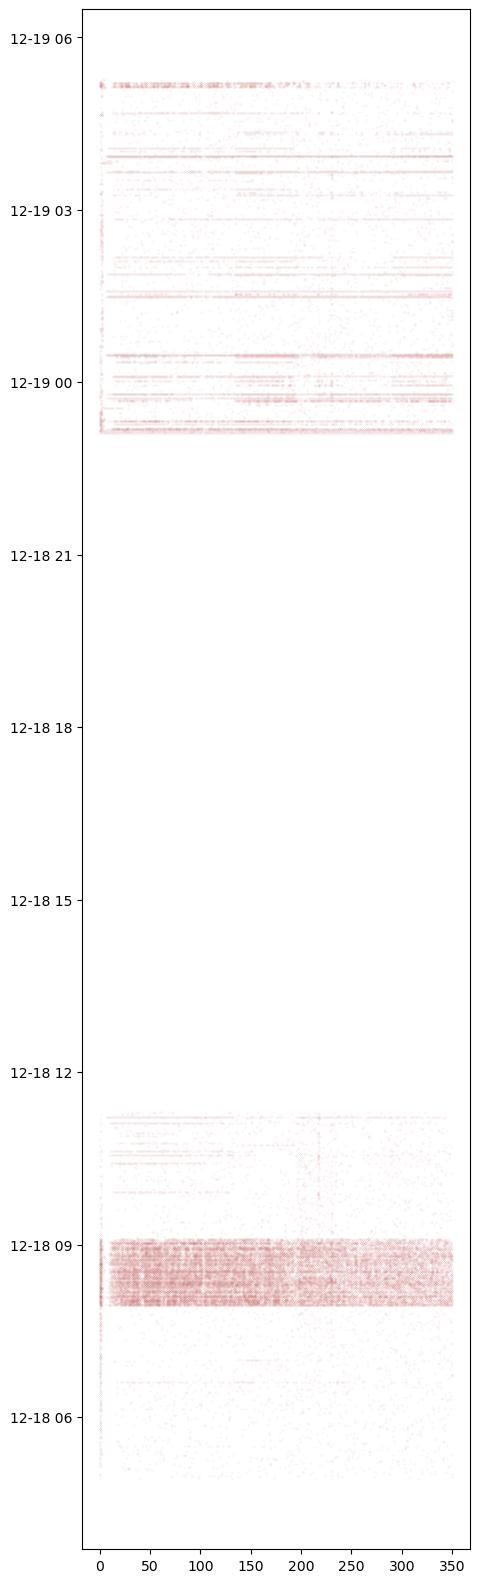

In [8]:
fig, ax = plt.subplots(figsize=(5,20))

for i in all_chans_all_detects_culled:
    start_times = all_chans_all_detects_culled[str(i)]
    chan = [int(i)] * len(all_chans_all_detects_culled[str(i)])
    ax.scatter(chan, start_times, s = .002, c = 'indianred' )

#ax.set_ylim([datetime.datetime(2024, 12, 18, 9, 0, 0, 0),datetime.datetime(2024, 12, 18, 9, 1, 0, 0)])

plt.show()

# 7.2 Show just a subset

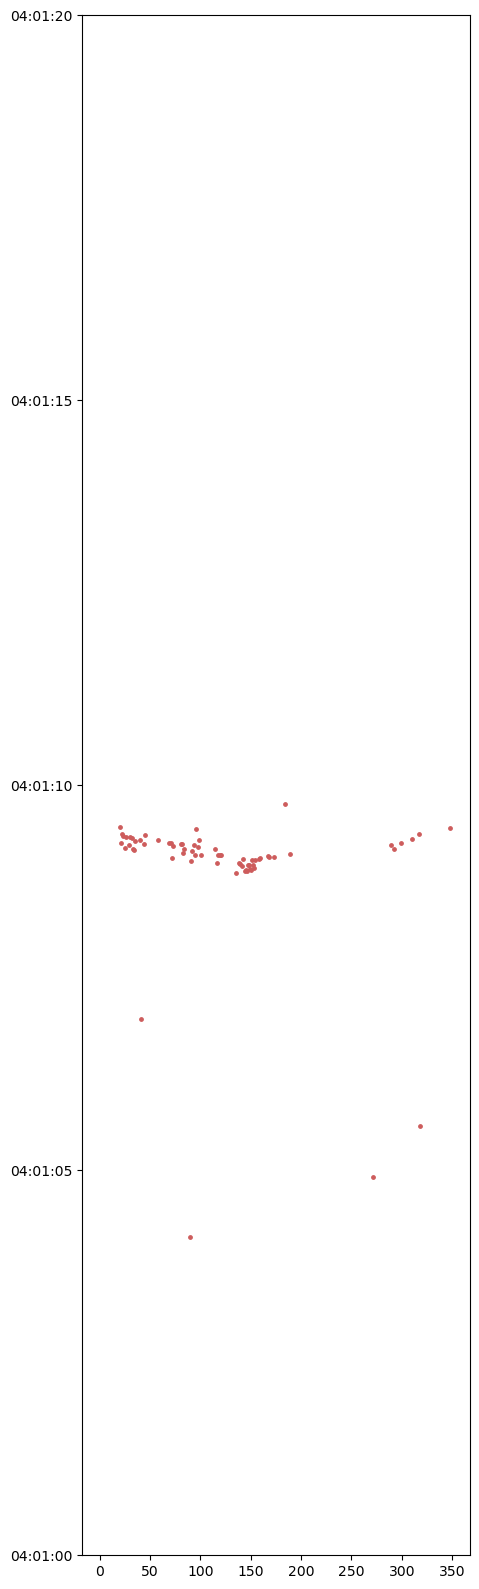

In [9]:
fig, ax = plt.subplots(figsize=(5,20))

for i in all_chans_all_detects_culled:
    start_times = all_chans_all_detects_culled[str(i)]
    chan = [int(i)] * len(all_chans_all_detects_culled[str(i)])
    ax.scatter(chan, start_times, s = 6, c = 'indianred' )

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

plt.show()

# 8. Filter events to only keep points near in space and time

In [10]:
def group_seismic_detections(detections, space_threshold, time_threshold_seconds):
    """
    Groups seismic wave detections based on spatial and temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats, representing space),
                           and values are lists of datetime objects (representing detections in time).
        space_threshold (float): Maximum distance between points to be considered in the same group.
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections.

    Returns:
        dict: Filtered and grouped detections with datetime values.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_datetimes = []  # Store original datetime values for reference

    for dist, times in detections.items():
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_datetimes.append(dt)  # Keep the original datetime

    if not data_points:
        return {}

    # Convert to NumPy array
    data_array = np.array(data_points)

    # Apply DBSCAN clustering (space in distance, time in seconds)
    clustering = DBSCAN(eps=max(space_threshold, time_threshold_seconds), min_samples=2, metric='euclidean').fit(data_array)

    # Extract labels
    labels = clustering.labels_

    # Remove noise points (-1 label)
    clustered_data = data_array[labels != -1]
    clustered_times = np.array(original_datetimes)[labels != -1]  # Keep corresponding original datetime values

    # Reorganize into a dictionary
    grouped_detections = {}
    for (dist, _), dt in zip(clustered_data, clustered_times):
        dist = round(float(dist), 5)  # Ensure floating point consistency
        if dist not in grouped_detections:
            grouped_detections[dist] = []
        grouped_detections[dist].append(dt)

    return grouped_detections




In [11]:
grouped_detections = group_seismic_detections(all_chans_all_detects_culled, 5, 1)

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


## 8.1 show filtered events

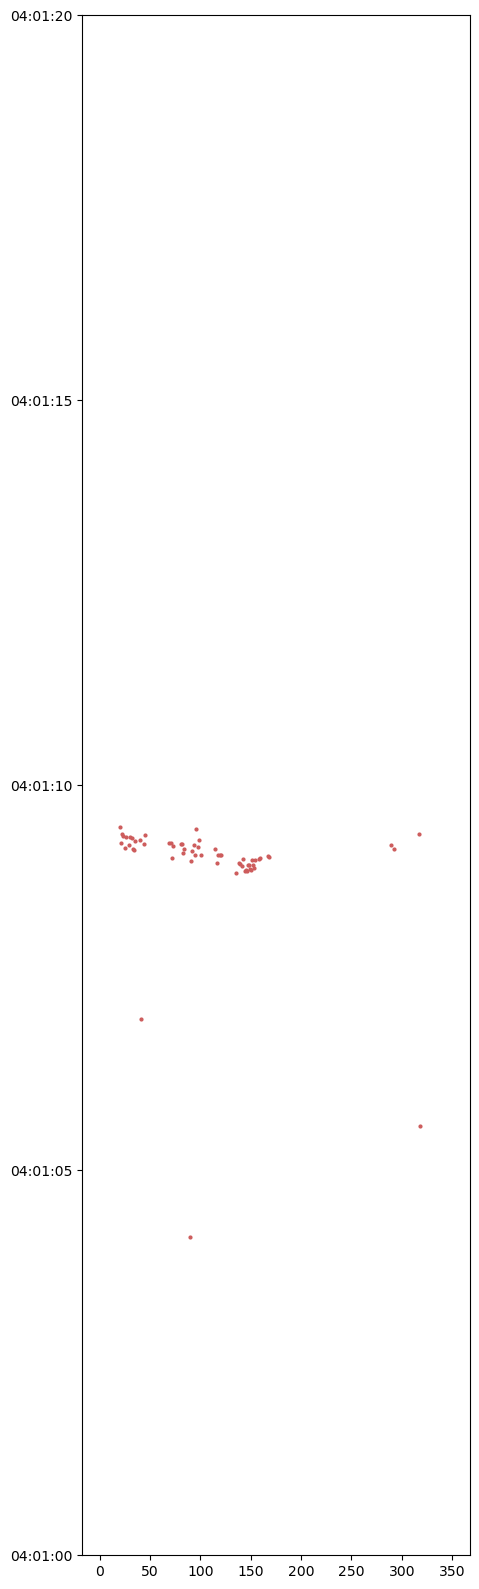

In [12]:
fig, ax = plt.subplots(figsize=(5,20))

for i in grouped_detections:
    start_times = grouped_detections[i]
    chan = [int(i)] * len(grouped_detections[i])
    ax.scatter(chan, start_times, s = 4, c = 'indianred' )

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

plt.show()

# 8.again Trying to group by event number now

In [13]:
def group_seismic_events(detections, time_threshold_seconds):
    """
    Groups seismic wave detections into events based on temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats or strings),
                           and values are lists of datetime objects (representing detections in time).
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections into the same event.

    Returns:
        list: A list of events, where each event is a list of (distance, datetime) tuples.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_data = []  # Store original (distance, datetime) pairs for reference

    for dist, times in detections.items():
        dist = float(dist)  # Convert distance to float if it's a string
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_data.append((dist, dt))  # Keep the original distance & datetime

    if not data_points:
        return []

    # Convert to NumPy array (only using time for clustering)
    time_array = np.array([[t] for _, t in data_points], dtype=np.float64)

    # Apply DBSCAN clustering based only on time
    clustering = DBSCAN(eps=time_threshold_seconds, min_samples=2, metric='euclidean').fit(time_array)

    # Extract labels
    labels = clustering.labels_

    # Group detections by event
    event_dict = {}
    for (dist, dt), label in zip(original_data, labels):
        if label == -1:
            continue  # Ignore noise (isolated detections)
        if label not in event_dict:
            event_dict[label] = []
        event_dict[label].append((dist, dt))

    # Convert to list format
    grouped_events = list(event_dict.values())

    return grouped_events

In [14]:
grouped_detections = group_seismic_events(grouped_detections, 1)

(20076.16736111111, 20076.167592592592)

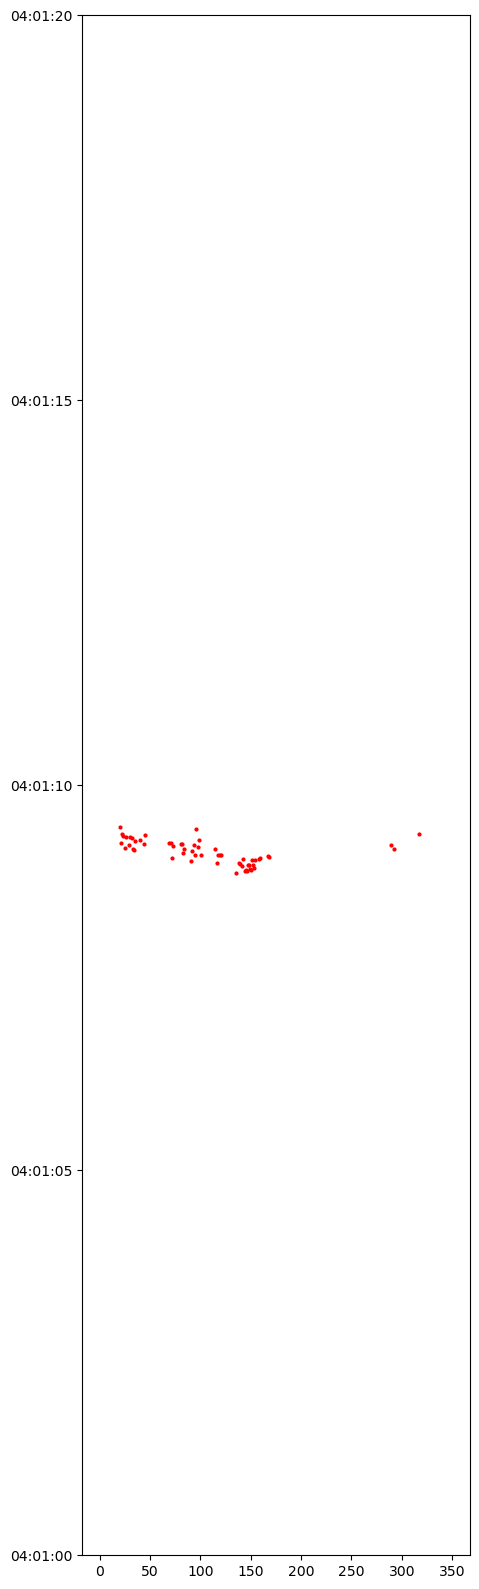

In [15]:
fig,ax = plt.subplots(figsize=(5,20))
for i, event in enumerate(grouped_detections):
    # print(f"Event {i+1}: {event}")
    cable_pos = np.asarray(event)[:,0]
    event_time = np.asarray(event)[:,1]
    ax.scatter(cable_pos, event_time, c = 'red', s = 4)

ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

## 8.again.2 Plot one event

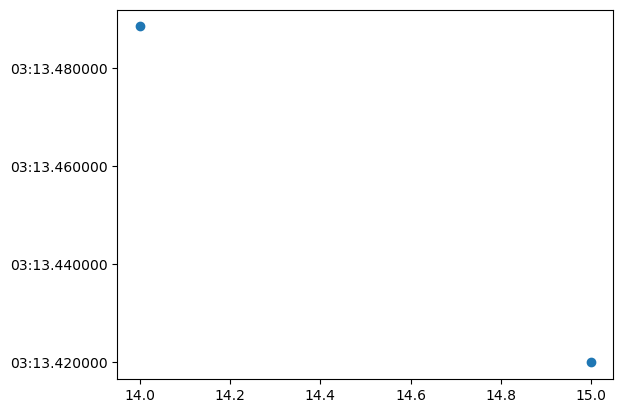

In [207]:
event_num = 311
event_arr = np.asarray(grouped_detections[event_num])
fig,ax = plt.subplots()
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

# 9. Further filter by only keeping events with more than "n" detections

In [16]:
def filter_small_events(events, min_detections):
    """
    Filters out events that have fewer than `min_detections` detections.

    Parameters:
        events (list): A list of events, where each event is a list of (distance, datetime) tuples.
        min_detections (int): Minimum number of detections required for an event to be kept.

    Returns:
        list: A filtered list of events with at least `min_detections` detections.
    """
    return [event for event in events if len(event) >= min_detections]

In [17]:
grouped_detections_culled = filter_small_events(grouped_detections, 20)

print(len(grouped_detections_culled))

289


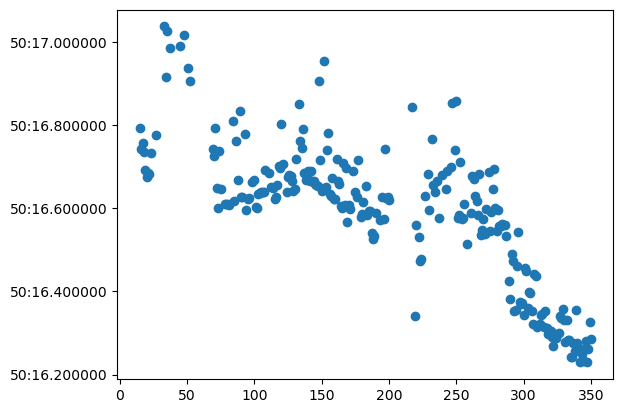

In [22]:
event_num = 219
event_arr = np.asarray(grouped_detections_culled[event_num])
fig,ax = plt.subplots()
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


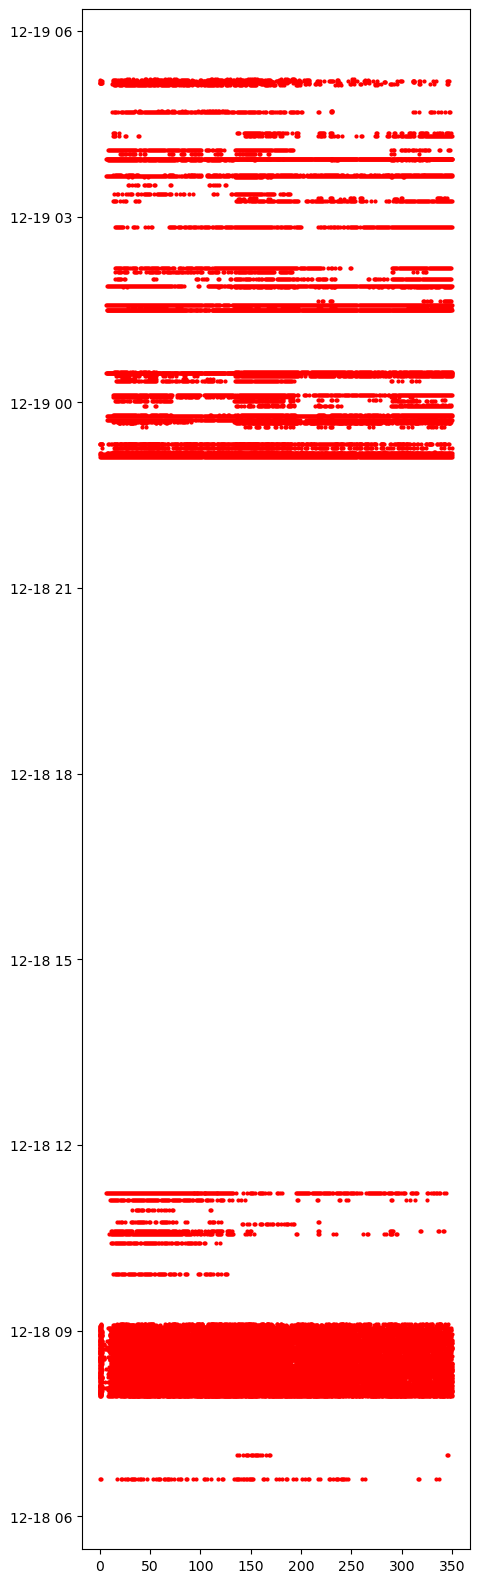

In [125]:
fig,ax = plt.subplots(figsize=(5,20))

for i in np.asarray(grouped_detections_culled):

    ax.scatter(np.asarray(i)[:,0], np.asarray(i)[:,1],  c = 'red', s = 4)

# ax.set_ylim([datetime.datetime(2024, 12, 19, 4, 1, 0, 0),datetime.datetime(2024, 12, 19, 4, 1, 20, 0)])

# 10. Plot the event and the data together to check accuracy

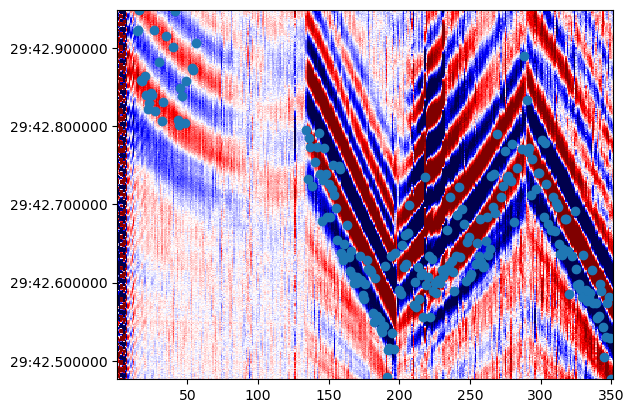

In [224]:

event_arr = np.asarray(grouped_detections_culled[event_num])

time_to_get = event_arr[:,1][0]
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time

f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,500], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

fig,ax = plt.subplots()
ax.pcolormesh(channels, times, filtered, vmin=-0.05, vmax=0.05, cmap='seismic')
ax.plot(event_arr[:,0], event_arr[:,1], 'o')

ax.set_ylim([event_arr[:,1].min(), event_arr[:,1].max()])
plt.show()

# 11. Fit a line to the detections on each section of cable

In [18]:
cable_sections = [[5,132],[137,192],[218,285],[292,350]]

test_event = np.asarray(grouped_detections_culled[312])

In [305]:


for i in cable_sections:
    points_to_consider = []
    for k in test_event:
        if i[0] <= k[0] <= i[1]:
            points_to_consider.append(k)

    points_to_consider = np.asarray(points_to_consider)
    best_line_coeffs = np.poly1d(np.polyfit(np.array(points_to_consider[:,0]).astype(float), mdates.date2num(points_to_consider[:,1]), 1))

    y_hat = np.polyval(best_line_coeffs, test_event[:,0])
    best_line_times = mdates.num2date(y_hat)
    print(best_line_coeffs)

 
-2.562e-08 x + 2.008e+04
 
-3.633e-08 x + 2.008e+04
 
4.347e-08 x + 2.008e+04
 
-5.467e-08 x + 2.008e+04


In [325]:
spd = 86400

events_line_coeffs = {}
events_v_and_t = {}
for n, event in enumerate(grouped_detections_culled):
    event = np.asarray(event)

    coeffs_4_sections = []
    vel_and_time = []
    for i in cable_sections:
        points_to_consider = []
        for k in event:
            if i[0] <= k[0] <= i[1]:
                points_to_consider.append(k)
        if len(points_to_consider) >= 3:
            points_to_consider = np.asarray(points_to_consider)
            best_line_coeffs = np.poly1d(np.polyfit(np.array(points_to_consider[:,0]).astype(float), mdates.date2num(points_to_consider[:,1]), 1))
            coeffs_4_sections.append(best_line_coeffs)
            
            apparent_velocity = 1/best_line_coeffs[1]/spd*dx
            date_b = mdates.num2date(best_line_coeffs[0])
            vel_and_time.append([date_b, apparent_velocity])
        else:
            coeffs_4_sections.append([])
            vel_and_time.append([])
        # y_hat = np.polyval(best_line_coeffs, event[:,0])
        # best_line_times = mdates.num2date(y_hat)

    events_line_coeffs["Event "+str(n)] = coeffs_4_sections
    events_v_and_t["Event "+str(n)] = vel_and_time


# 12. Get times to a float number instead of datetime

In [246]:
grouped_detections_culled_arr = np.asarray(grouped_detections_culled)
picks_all = [[np.asarray(i)[:,0], mdates.date2num(np.asarray(i)[:,1])] for i in grouped_detections_culled_arr]

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [256]:
grouped_detections_culled_arr = np.asarray(grouped_detections_culled)
picks_all = [[np.asarray(i)[:,0], [(dt - datetime.datetime(1970, 1, 1)).total_seconds() for dt in np.asarray(i)[:, 1]]] for i in grouped_detections_culled_arr]

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


# 13. Load the cable locations CSV

In [24]:
cable_loc = pd.read_csv('eastwind_coordinates_utm59s.csv', header=None)
cable_loc.rename(columns={0:'name', 1:'y', 2:'x', 3:'z'}, inplace=True)

In [25]:
cable_sections = [[0,132],[133,136], [137,192],[193,217],[218,285],[286,291],[292,350]]
cable_loc_names = [['D_0','D_12'],['D_12','D_17'], ['D_17','D_26'],['D_26','D_31'],['D_31','D_40'],['D_40','D_43'],['D_43','D_49']]


In [26]:
channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0]
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0]

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0]
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)

    for x,y in zip(x_vals, y_vals):
        channel_locations.append([x,y])

channel_locations = np.asarray(channel_locations)

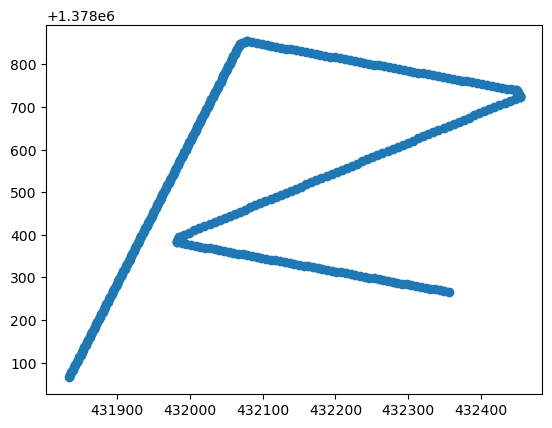

In [27]:
fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])

## Load the imagery

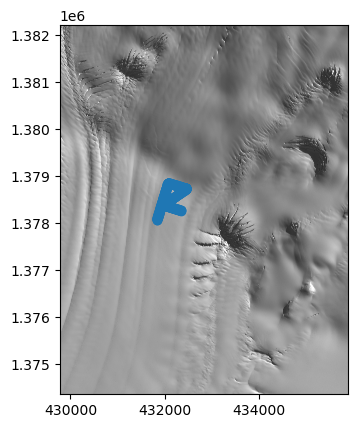

In [28]:
from rasterio.plot import show

# Specify the path to the GeoPackage file
gpkg_path = "imagery/eastwind_image_reproject_AOI_clip.tif"

fig,ax = plt.subplots()


# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed


ax.scatter(channel_locations[:,0], channel_locations[:,1])



# 14: Inverse Problem

In [356]:
### Priors ###
top_lim = 1390000
bottom_lim = 1376000

right_lim = 436000
left_lim = 428000

# min_offset = np.hstack(np.array(picks_all)[:,1]).min()
# max_offset = np.hstack(np.array(picks_all)[:,1]).max()

wavespeed_min = 100
wavespeed_max = 3000

### Functions ###
def log_prior(theta, picks):
    s_x,s_y,t_offset,c = theta

    min_offset = np.array(picks[1]).min() - 1
    max_offset = np.array(picks[1]).min()
    if left_lim < s_x < right_lim and bottom_lim < s_y < top_lim and min_offset < t_offset < max_offset and wavespeed_min < c < wavespeed_max:
        return 0.0
    return -np.inf

def log_likelihood(theta, picks):
    s_x,s_y,t_offset,c = theta
    chans_of_picks = np.array(picks[0], dtype=int)

    distance = np.sqrt((channel_locations[chans_of_picks,0]-s_x)**2 + (channel_locations[chans_of_picks,1]-s_y)**2)   
    

    model = distance/c + t_offset

    #model =  (t_offset*86400) + np.linalg.norm(channel_locations[chans_of_picks,:] - np.array([s_x, s_y]), axis=0) / c
    ll = - np.sum(np.abs(model - picks[1]))

    return ll

def log_probability(theta, picks):
    lp = log_prior(theta, picks)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, picks)

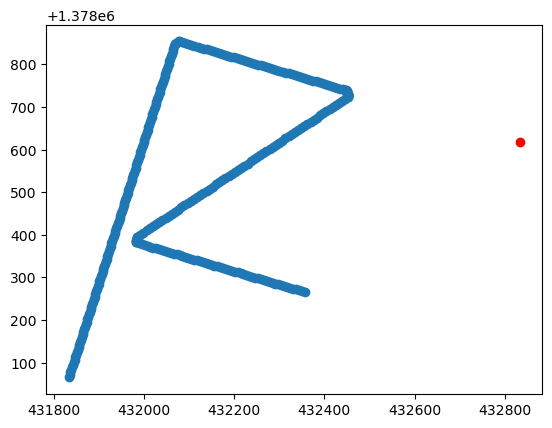

In [357]:
# Make an initial guess on the source location
s_x_init = 432833.2600664
s_y_init = 1378618.37797727


fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter([s_x_init], [s_y_init], c='red')

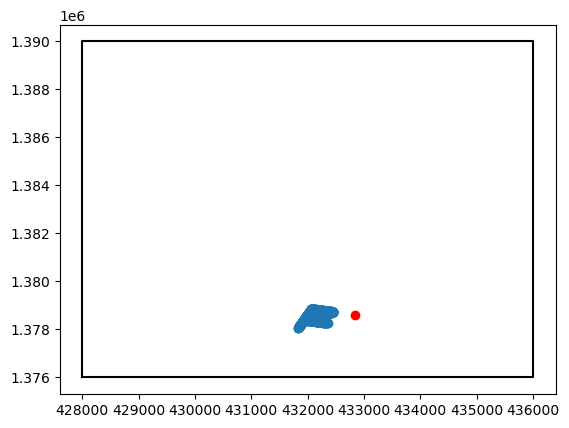

In [358]:
### Region of interest

fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter([s_x_init], [s_y_init], c='red')
ax.plot([left_lim,left_lim, right_lim, right_lim, left_lim],[bottom_lim,top_lim, top_lim, bottom_lim, bottom_lim], '-k')

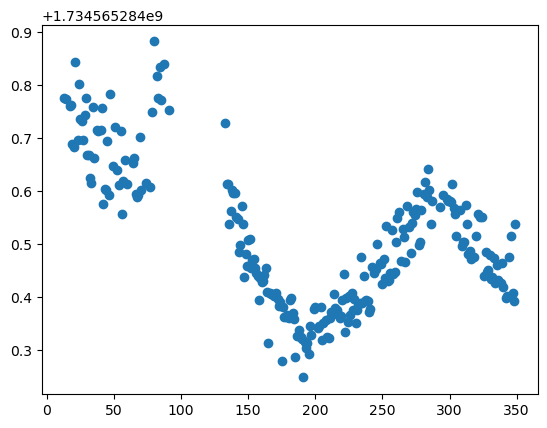

In [359]:
# Take one example to test ###
picks = picks_all[199]

fig, ax = plt.subplots()
ax.plot(picks[0], picks[1], 'o')

In [360]:
### Make an inital guess on the time offset and velocity ###

offset_init = np.array(picks[1]).min() -0
c_init = 1000

### initial guesses ###
num_resets = 50

init_guesses = np.array([s_x_init, s_y_init, offset_init, c_init])

initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) * np.array([2e3, 2e3, 1e-6, 1e2])

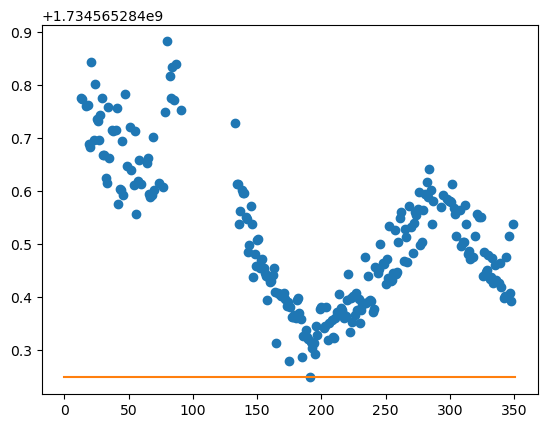

In [361]:
fig, ax = plt.subplots()
ax.plot(picks[0], picks[1], 'o')
ax.plot([0,351],[offset_init, offset_init])

In [362]:
### Run the MCMC  on just one for a test ###

nwalkers, ndim = initial.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=[picks]
)
sampler.run_mcmc(initial, 2000, progress=True);

100%|██████████| 2000/2000 [00:07<00:00, 266.09it/s]


In [363]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(6300, 4)


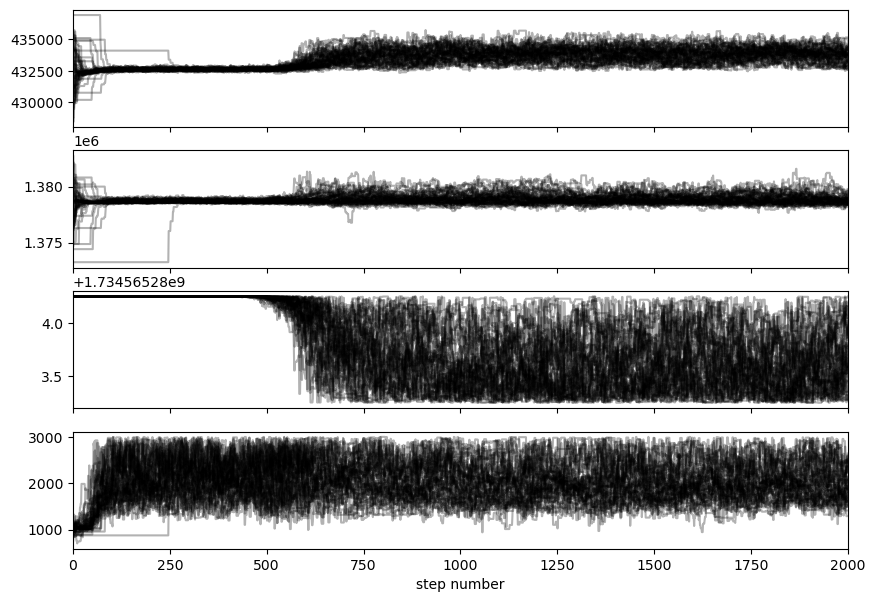

In [364]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))

    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

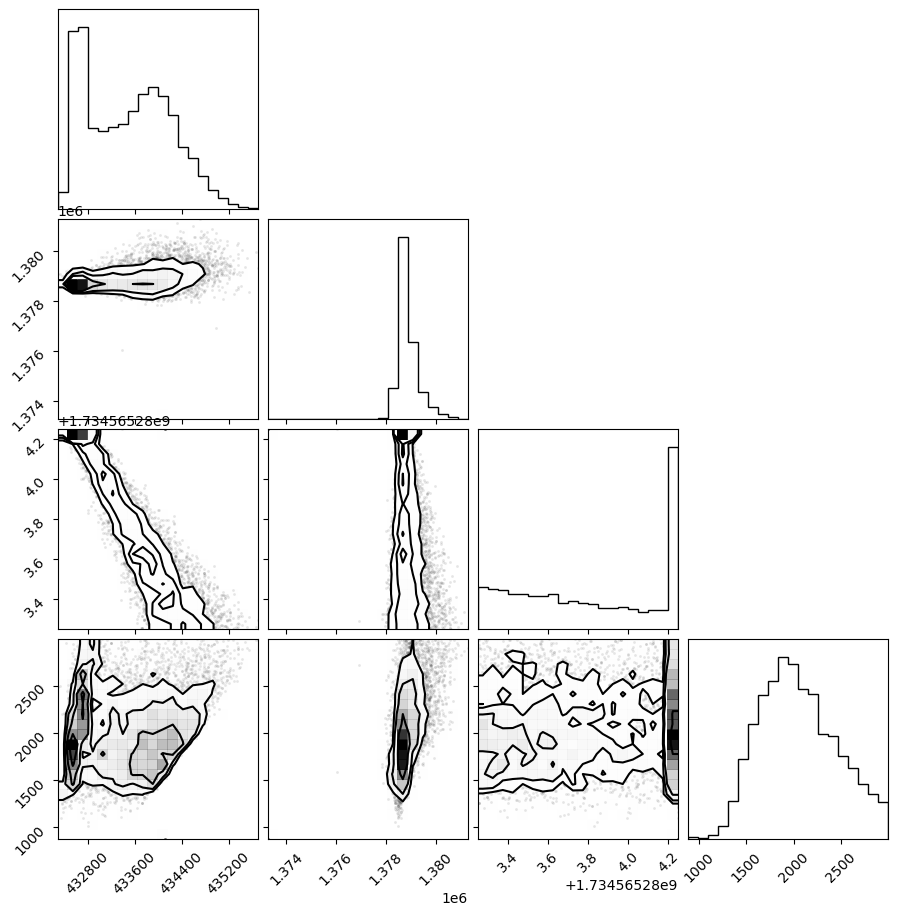

In [365]:
import corner

fig = corner.corner(
    flat_samples
);

In [366]:
median_x = np.median(flat_samples[:,0])
median_y = np.median(flat_samples[:,1])
median_offset = np.median(flat_samples[:,2])
median_c = np.median(flat_samples[:,3])

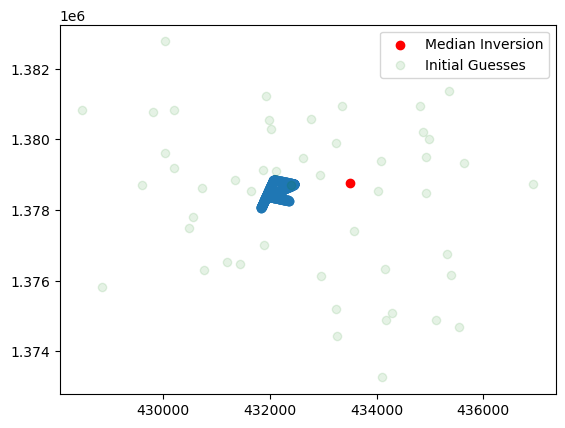

In [367]:
# Median inversion on the source location

fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter([median_x], [median_y], c='red', label='Median Inversion')
ax.scatter(initial[:,0], initial[:,1], c='green', alpha=0.1, label='Initial Guesses')
ax.legend()

### Run EMCEE for all picks

In [372]:
### Make an inital guess on the time offset and velocity ###


c_init = 1000
# Make an initial guess on the source location, basically the middle
s_x_init = 432033.2600664
s_y_init = 1378618.37797727

### initial guesses ###
num_resets = 50

init_guesses = np.array([s_x_init, s_y_init, offset_init, c_init])

initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) *  np.array([2e3, 2e3, 1e-6, 1e2])

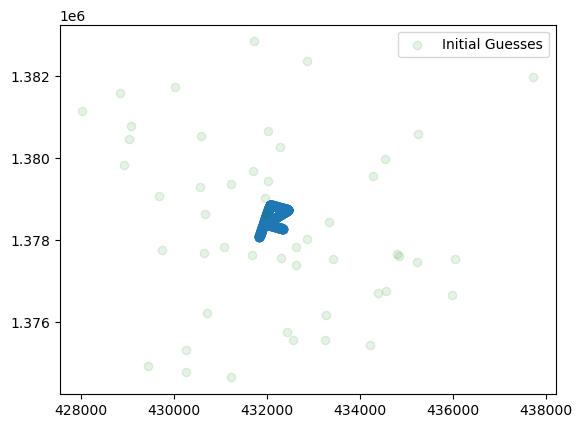

In [373]:
fig,ax = plt.subplots()
ax.scatter(channel_locations[:,0], channel_locations[:,1])
ax.scatter(initial[:,0], initial[:,1], c='green', alpha=0.1, label='Initial Guesses')
ax.legend()

100%|██████████| 289/289 [14:11<00:00,  2.95s/it]


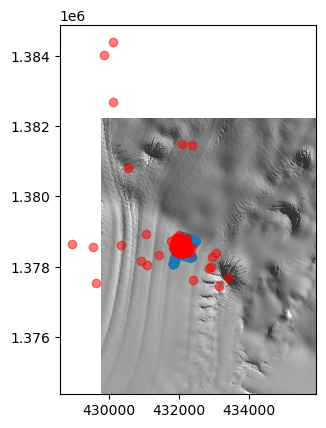

In [374]:
### Run the inversion for all picks ###
fig,ax = plt.subplots()

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed
ax.scatter(channel_locations[:,0], channel_locations[:,1])


flat_samples_all = {}

n = 0 
for picks in tqdm(picks_all):
    ## make the initial offset pick the time of the first arrival ##
    offset_init = picks[1][0] - 1e-7

    ## make the initial guess array ##
    init_guesses = np.array([s_x_init, s_y_init, offset_init, c_init])

    initial = init_guesses + np.random.randn(num_resets, len(init_guesses)) *  np.array([5e2, 5e2, 1e-6, 1e2])
    nwalkers, ndim = initial.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=[picks]
    )
    sampler.run_mcmc(initial, 2000);

    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    flat_samples_all['Event ' + str(n)] = flat_samples
    median_x = np.median(flat_samples[:,0])
    median_y = np.median(flat_samples[:,1])
    median_offset = np.median(flat_samples[:,2])
    median_c = np.median(flat_samples[:,3])
    ax.scatter([median_x], [median_y], c='red', alpha=0.5)

    n+=1

array([[4.31932067e+05, 1.37900340e+06, 1.73456528e+09, 1.09082845e+03],
       [4.32142154e+05, 1.37858783e+06, 1.73456528e+09, 9.52866356e+02],
       [4.31922278e+05, 1.37775620e+06, 1.73456528e+09, 1.22249415e+03],
       ...,
       [4.32342707e+05, 1.37883847e+06, 1.73456528e+09, 8.74558283e+02],
       [4.32265490e+05, 1.37888050e+06, 1.73456528e+09, 9.67332767e+02],
       [4.32373603e+05, 1.37885907e+06, 1.73456528e+09, 9.13006412e+02]])

## 15. Plot heatmap of single event

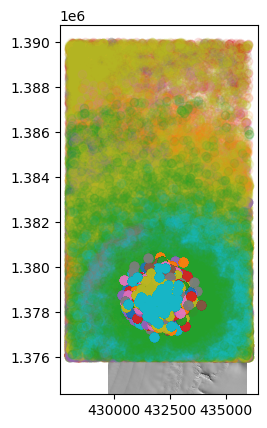

In [394]:



fig,ax = plt.subplots()

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed
ax.scatter(channel_locations[:,0], channel_locations[:,1])
for i in flat_samples_all:
    event_heat = flat_samples_all[i][:,0:2]
    ax.scatter(event_heat[:,0], event_heat[:,1],alpha=0.1)

# Inverse example

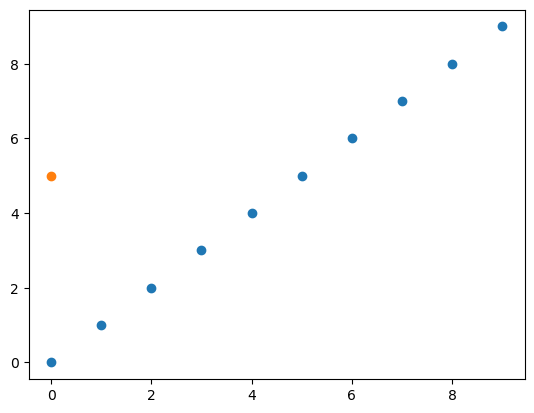

In [332]:
source = np.array([0,5])
recievers = np.array([np.arange(10),np.arange(10)])
fig,ax = plt.subplots()
ax.scatter(*recievers)
ax.scatter(*source)

In [1]:
c_apparent = 1000

travel_times = np.sqrt(np.sum((recievers.T - source[:,None].T)**2, axis=1))/c_apparent

fig,ax = plt.subplots()
ax.plot(travel_times)

NameError: name 'np' is not defined

In [342]:
## Change the apparent velocity to arrival times for each channel
## feed it with the more or less raw picks

100%|██████████| 5000/5000 [00:07<00:00, 668.85it/s]


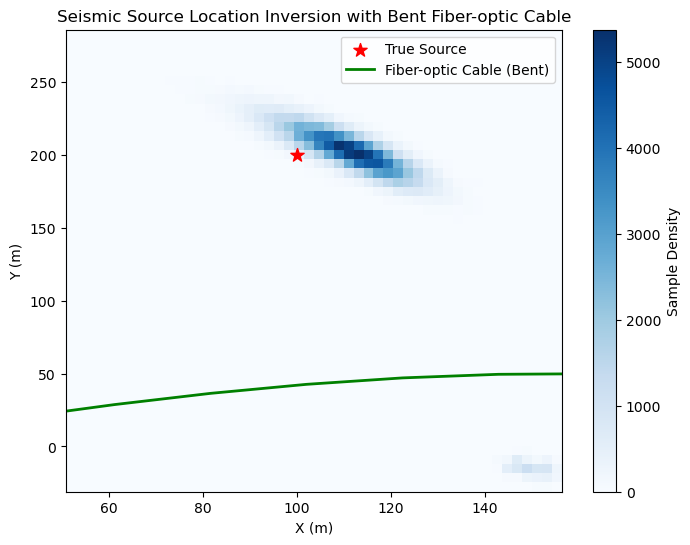

In [186]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

# Parameters for bent fiber-optic sensor positions (e.g., sinusoidal curve for bending)
sensor_count = 50  # Number of sensors
x_start, x_end = 0, 1000  # X-range of the fiber-optic cable
bend_amplitude = 50  # Amplitude of the bend (in meters)
bend_frequency = 0.01  # Frequency of the bend (how tightly it bends)

# Generate the sensor positions along the bent array
sensor_x = np.linspace(x_start, x_end, sensor_count)
sensor_y = bend_amplitude * np.sin(bend_frequency * sensor_x)  # Simple sinusoidal bend

sensor_positions = np.vstack([sensor_x, sensor_y]).T

# Simulated first arrival times (or use real data)
true_source = [100, 200]  # True source position
true_t_offset = 0.0  # True origin time
velocity = 3000  # m/s (P-wave velocity)

# Compute synthetic arrival times
true_arrival_times = true_t_offset + np.linalg.norm(sensor_positions - true_source, axis=1) / velocity

# Add noise to simulate measurement uncertainty
observed_times = true_arrival_times + np.random.normal(0, 0.005, size=len(sensor_positions))

# Define log-likelihood function
def log_likelihood(params, observed_times, sensor_positions, velocity):
    x, y, t_offset = params
    predicted_times = t_offset + np.linalg.norm(sensor_positions - np.array([x, y]), axis=1) / velocity
    residuals = observed_times - predicted_times
    sigma_t = 0.005  # Arrival time uncertainty (seconds)
    return -0.5 * np.sum((residuals / sigma_t) ** 2)

# Define log-prior function
def log_prior(params):
    x, y, t_offset = params
    if 0 < x < 1000 and -500 < y < 500:  # Assume source is within reasonable bounds
        return -0.5 * ((t_offset - 0) / 0.1) ** 2  # Gaussian prior for t_offset
    return -np.inf  # Outside bounds

# Define posterior function
def log_posterior(params, observed_times, sensor_positions, velocity):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, observed_times, sensor_positions, velocity)

# Set up MCMC sampling
ndim = 3  # (x, y, t_offset)
nwalkers = 50
initial_x = np.random.uniform(400, 600, nwalkers)
initial_y = np.random.uniform(100, 300, nwalkers)
initial_t_offset = np.random.normal(0, 0.02, nwalkers)
p0 = np.vstack([initial_x, initial_y, initial_t_offset]).T

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(observed_times, sensor_positions, velocity))
sampler.run_mcmc(p0, 5000, progress=True)

# Extract samples
samples = sampler.get_chain(discard=1000, flat=True)

# Plot results
plt.figure(figsize=(8, 6))
plt.hist2d(samples[:, 0], samples[:, 1], bins=50, cmap="Blues")
plt.colorbar(label="Sample Density")
plt.scatter(true_source[0], true_source[1], color="red", marker="*", s=100, label="True Source")
plt.plot(sensor_x, sensor_y, label="Fiber-optic Cable (Bent)", color="green", lw=2)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("Seismic Source Location Inversion with Bent Fiber-optic Cable")
plt.show()


